In [1]:
import copy
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# set path to datasets
PATH_TO_RPKM_DATA = "./data/CCLE_RNAseq_genes_rpkm_20180929.gct"
PATH_TO_ANTICANCER_DRUG_DATA = "./data/CCLE_NP24.2009_Drug_data_2015.02.24.csv"

In [3]:
# reading RPKM data
# first two rows and first two columns are irrelevant
# index_col can be used to set the row names
RPKMData = pd.read_csv(PATH_TO_RPKM_DATA, sep = '\t', skiprows = 2, index_col = 0)

drugData = pd.read_csv(PATH_TO_ANTICANCER_DRUG_DATA, delimiter=',')

In [4]:
# identifying compounds in dataset
allCompounds = drugData['Compound'].unique()
print(allCompounds)

# separate data by compound 
drugDataByCompound = {compound : drugData.loc[drugData['Compound'] == compound] for compound in allCompounds}
print(drugDataByCompound[allCompounds[0]])

['AEW541' 'Nilotinib' '17-AAG' 'PHA-665752' 'Lapatinib' 'Nutlin-3'
 'AZD0530' 'PF2341066' 'L-685458' 'ZD-6474' 'Panobinostat' 'Sorafenib'
 'Irinotecan' 'Topotecan' 'LBW242' 'PD-0325901' 'PD-0332991' 'Paclitaxel'
 'AZD6244' 'PLX4720' 'RAF265' 'TAE684' 'TKI258' 'Erlotinib']
               CCLE Cell Line Name Primary Cell Line Name Compound Target  \
0    1321N1_CENTRAL_NERVOUS_SYSTEM                 1321N1   AEW541  IGF1R   
1                   22RV1_PROSTATE                  22Rv1   AEW541  IGF1R   
2    42MGBA_CENTRAL_NERVOUS_SYSTEM               42-MG-BA   AEW541  IGF1R   
3               5637_URINARY_TRACT                   5637   AEW541  IGF1R   
4               639V_URINARY_TRACT                  639-V   AEW541  IGF1R   
..                             ...                    ...      ...    ...   
498                      WM88_SKIN                  WM-88   AEW541  IGF1R   
499                    WM983B_SKIN                WM-983B   AEW541  IGF1R   
500    YKG1_CENTRAL_NERVOUS_SYSTEM

In [5]:
# sort data per compound by IC50
for compound in allCompounds:
    sortData = copy.deepcopy(drugDataByCompound[compound])
    sortData.sort_values(by = ['IC50 (uM)'], inplace = True)
    drugDataByCompound[compound] = sortData
print(drugDataByCompound[allCompounds[0]])

                            CCLE Cell Line Name Primary Cell Line Name  \
321                               NCIH2122_LUNG              NCI-H2122   
170                                  IGR37_SKIN                 IGR-37   
428                     SKNFI_AUTONOMIC_GANGLIA                SK-N-FI   
444  SUDHL10_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE              SU-DHL-10   
21      AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE                  AMO-1   
..                                          ...                    ...   
231                           KYSE30_OESOPHAGUS                KYSE-30   
229                          KYSE150_OESOPHAGUS               KYSE-150   
227                            KYM1_SOFT_TISSUE                  KYM-1   
222                                KP3_PANCREAS                   KP-3   
502                               ZR7530_BREAST               ZR-75-30   

    Compound Target                            Doses (uM)  \
321   AEW541  IGF1R  .0025,.0080,.025,.080,.25,.80

[]

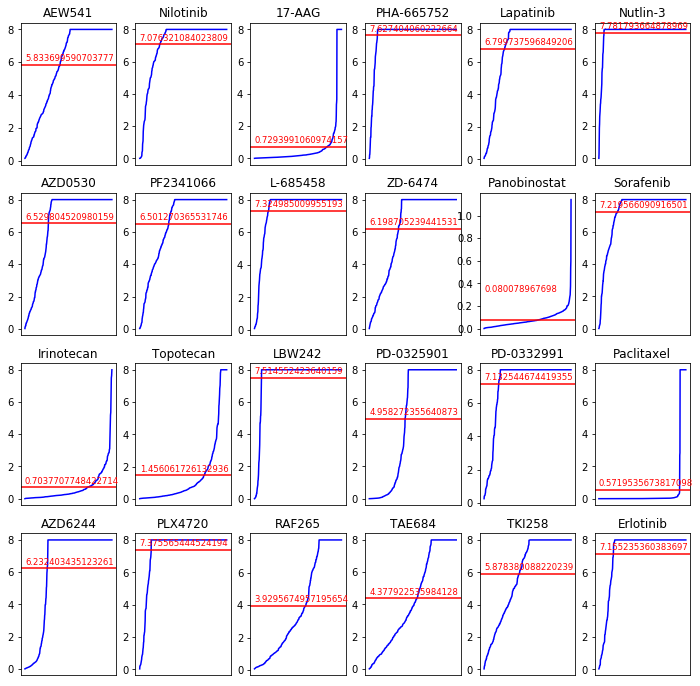

In [6]:
fig, axes = plt.subplots(4, 6, figsize = (12, 12))
fig.set_facecolor('w')
for i in range(4):
    for j in range(6):
        compound = allCompounds[i*6 + j]
        axes[i, j].plot(drugDataByCompound[compound]['CCLE Cell Line Name'], drugDataByCompound[compound]['IC50 (uM)'], color = 'b')
        axes[i, j].axhline(y = drugDataByCompound[compound]['IC50 (uM)'].mean(), color = 'r')
        axes[i, j].text(0, drugDataByCompound[compound]['IC50 (uM)'].mean() + 0.25, str(drugDataByCompound[compound]['IC50 (uM)'].mean()), color = 'r', fontsize = 8.5)
        axes[i, j].set_title(compound)
plt.setp(plt.gcf().get_axes(), xticks=[])

In [7]:
# extract IC50 data for a given compound
compound = 'RAF265'
ic50 = pd.Series(list(drugDataByCompound[compound]['IC50 (uM)']), index = list(drugDataByCompound[compound]['CCLE Cell Line Name']))
print(ic50)

F36P_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    0.082872
SKES1_BONE                                 0.096143
TOV21G_OVARY                               0.117165
IPC298_SKIN                                0.125808
HS840T_UPPER_AERODIGESTIVE_TRACT           0.126825
                                             ...   
HS852T_SKIN                                8.000000
MOGGCCM_CENTRAL_NERVOUS_SYSTEM             8.000000
RERFLCAI_LUNG                              8.000000
HS936T_SKIN                                8.000000
1321N1_CENTRAL_NERVOUS_SYSTEM              8.000000
Length: 460, dtype: float64


In [8]:
# limit data to samples with IC50 data and RPKM data
all_samples = list(set(RPKMData.columns) & set(ic50.index))
ic50 = ic50[all_samples]
print(ic50)

HT29_LARGE_INTESTINE            0.819590
NCIH1915_LUNG                   0.223404
CAL851_BREAST                   0.650694
KNS42_CENTRAL_NERVOUS_SYSTEM    5.805481
SAOS2_BONE                      8.000000
                                  ...   
HPAC_PANCREAS                   2.475223
CAS1_CENTRAL_NERVOUS_SYSTEM     8.000000
NCIH28_PLEURA                   3.970736
C32_SKIN                        8.000000
EFM19_BREAST                    2.197539
Length: 426, dtype: float64


In [9]:
# convert IC50 data into resistant/sensitive labels based on mean()
drug_response = pd.Series(['Resistant' if item > ic50.mean() else 'Sensitive' for i, item in ic50.iteritems()], index = ic50.index)
print(drug_response)

HT29_LARGE_INTESTINE            Sensitive
NCIH1915_LUNG                   Sensitive
CAL851_BREAST                   Sensitive
KNS42_CENTRAL_NERVOUS_SYSTEM    Resistant
SAOS2_BONE                      Resistant
                                  ...    
HPAC_PANCREAS                   Sensitive
CAS1_CENTRAL_NERVOUS_SYSTEM     Resistant
NCIH28_PLEURA                   Resistant
C32_SKIN                        Resistant
EFM19_BREAST                    Sensitive
Length: 426, dtype: object


In [10]:
# randomly assign samples to bins
random_seed = 1234
n_bins = 10
sample_bins = {}
drug_response = drug_response.sample(frac = 1, random_state = random_seed)
for i, sample in enumerate(drug_response.index):
    sample_bins.setdefault(i%n_bins,[]).append(sample)

In [11]:
cancer_types_map = drug_response.index.tolist()
for i in range(len(cancer_types_map)):
    cancer_types_map[i] = cancer_types_map[i][cancer_types_map[i].find('_') + 1:]

cancer_types_map = list(set(cancer_types_map))
cancer_types_map

['SKIN',
 'KIDNEY',
 'CENTRAL_NERVOUS_SYSTEM',
 'LIVER',
 'AUTONOMIC_GANGLIA',
 'STOMACH',
 'THYROID',
 'PANCREAS',
 'PLEURA',
 'OVARY',
 'URINARY_TRACT',
 'OESOPHAGUS',
 'BONE',
 'LARGE_INTESTINE',
 'SALIVARY_GLAND',
 'UPPER_AERODIGESTIVE_TRACT',
 'SOFT_TISSUE',
 'ENDOMETRIUM',
 'PROSTATE',
 'BREAST',
 'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'LUNG',
 'BILIARY_TRACT']

In [12]:
test_bin = 0
train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
train_labels = drug_response[train_samples]
train_RPKM = RPKMData[train_samples].transpose()

test_samples = sample_bins[test_bin]
test_labels = drug_response[test_samples]
test_RPKM = RPKMData[test_samples].transpose()

# copy train samples
# for loop and crop out left of first instance of '_'
# append to the training dataframe
cancer_train_samples = train_samples
for i in range(len(cancer_train_samples)):
    cancer_type = cancer_train_samples[i][cancer_train_samples[i].find('_') + 1:]
    cancer_train_samples[i] = cancer_types_map.index(cancer_type)
train_RPKM["Cancer"] = cancer_train_samples

cancer_test_samples = test_samples
for i in range(len(cancer_test_samples)):
    cancer_type = cancer_test_samples[i][cancer_test_samples[i].find('_') + 1:]
    cancer_test_samples[i] = cancer_types_map.index(cancer_type)
test_RPKM["Cancer"] = cancer_test_samples

In [13]:
RPKMData

,Description,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,DDX11L1,0.053448,0.043078,0.037956,0.028313,0.009377,0.004012,0.017452,0.013608,0.018103,...,0.180119,0.102898,0.354700,0.418945,0.270819,0.096412,0.116833,0.025481,0.124122,0.030062
ENSG00000227232.4,WASH7P,5.752560,4.261040,3.100480,3.079090,3.994940,3.356750,2.569410,3.025490,2.787330,...,5.420360,2.323580,5.666570,2.795510,2.432770,3.703760,3.163270,3.983540,4.601320,4.563500
ENSG00000243485.2,MIR1302-11,0.039576,0.011961,0.031618,0.031446,0.020831,0.053476,0.029075,0.040305,0.040212,...,0.244510,0.114286,0.472748,0.572692,0.481268,0.091785,0.070780,0.011320,0.127255,0.055648
ENSG00000237613.2,FAM138A,0.037400,0.022608,0.013280,0.026416,0.006562,0.022461,0.018318,0.006348,0.012667,...,0.196060,0.164578,0.384714,0.285641,0.363853,0.077102,0.104051,0.000000,0.133623,0.028048
ENSG00000268020.2,OR4G4P,0.000000,0.019401,0.025642,0.008501,0.008447,0.000000,0.007860,0.016343,0.000000,...,0.144213,0.039722,0.239619,0.135462,0.097575,0.037218,0.095669,0.036722,0.051601,0.018052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,MT-ND6,1794.950000,1974.760000,2097.980000,3909.720000,1622.680000,1201.490000,1900.100000,1426.190000,1157.280000,...,2113.220000,1320.950000,4827.860000,5515.710000,2294.250000,1265.590000,1291.400000,920.342000,1326.890000,2597.320000
ENSG00000210194.1,MT-TE,4.625190,3.062130,1.290380,3.850100,2.550380,2.876880,37.648000,2.579540,1.678430,...,3.216320,1.090330,4.384910,14.873400,5.088890,2.554020,3.151250,2.898010,2.124610,2.601420
ENSG00000198727.2,MT-CYB,4630.210000,3685.240000,1778.510000,4159.000000,2215.690000,1932.630000,1975.030000,1573.770000,2727.260000,...,1361.440000,2163.490000,11273.200000,6164.490000,2980.420000,1489.780000,1350.810000,1844.600000,1277.070000,5165.040000


In [14]:
train_rf = RandomForestClassifier(n_estimators = 256, random_state = random_seed)
train_rf.fit(train_RPKM, train_labels)
test_predictions = pd.Series(train_rf.predict(test_RPKM), index = test_RPKM.index)

# compares predictions against actual labels to get accuracy
print(sum(test_predictions == test_labels)/len(test_predictions))

0.5348837209302325


In [15]:
feature_importances

NameError: name 'feature_importances' is not defined

In [ ]:
feature_importances = pd.Series(train_rf.feature_importances_, index = train_RPKM.columns)
feature_importances.loc[(feature_importances!=0).any()]
print(test_RPKM.index)

In [ ]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [ ]:
validation = RPKMData.filter(['Name', 'Description'], axis=1)

bin1 = RPKMData.filter([0], axis=1)
bin2 = RPKMData.filter([0], axis=1)
bin3 = RPKMData.filter([0], axis=1)
bin4 = RPKMData.filter([0], axis=1)
bin5 = RPKMData.filter([0], axis=1)
bin6 = RPKMData.filter([0], axis=1)
bin7 = RPKMData.filter([0], axis=1)
bin8 = RPKMData.filter([0], axis=1)
bin9 = RPKMData.filter([0], axis=1)
bin10 = RPKMData.filter([0], axis=1)

In [ ]:
cellLine = RPKMData.columns.tolist()
cellLine.remove('Name')
cellLine.remove('Description')

In [ ]:
len(list(drugData['CCLE Cell Line Name'].unique()))

In [ ]:
def removeNull(a):
    result = list(filter(None, a)) 
    return result

In [ ]:
uniqueCCLE = list(drugData['CCLE Cell Line Name'].unique())

for i in range(0, len(cellLine)):
    if cellLine[i] not in set(uniqueCCLE):
        cellLine[i] = None
        
cellLine = removeNull(cellLine)

In [ ]:
for i in range(0, len(cellLine), 5):
    if cellLine[i] != None:
        validation.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 5
        
cellLine = removeNull(cellLine)
print(len(cellLine))

In [ ]:
# bin1
for i in range(0, 37):
    if cellLine[i] != None:
        bin1.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin2
for i in range(0, 37):
    if cellLine[i] != None:
        bin2.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)
   
# bin3
for i in range(0, 37):
    if cellLine[i] != None:
        bin3.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin4
for i in range(0, 37):
    if cellLine[i] != None:
        bin4.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin5
for i in range(0, 37):
    if cellLine[i] != None:
        bin5.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin6
for i in range(0, 38):
    if cellLine[i] != None:
        bin6.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)
   
# bin7
for i in range(0, 38):
    if cellLine[i] != None:
        bin7.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin8
for i in range(0, 38):
    if cellLine[i] != None:
        bin8.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)
   
# bin9
for i in range(0, 38):
    if cellLine[i] != None:
        bin9.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

# bin10
for i in range(0, 38):
    if cellLine[i] != None:
        bin10.loc[:,cellLine[i]] = RPKMData.loc[:,cellLine[i]]
        cellLine[i] = None
    else:
        i -= 1
cellLine = removeNull(cellLine)

In [ ]:
concat = [bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10]
noBin1 = pd.concat(concat, axis=1)

concat = [bin1, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10]
noBin2 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin4, bin5, bin6, bin7, bin8, bin9, bin10]
noBin3 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin5, bin6, bin7, bin8, bin9, bin10]
noBin4 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin6, bin7, bin8, bin9, bin10]
noBin5 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin5, bin7, bin8, bin9, bin10]
noBin6 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin5, bin6, bin8, bin9, bin10]
noBin7 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin9, bin10]
noBin8 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin10]
noBin9 = pd.concat(concat, axis=1)

concat = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]
noBin10 = pd.concat(concat, axis=1)


RUNNING DRUG MODEL

In [ ]:
def modelAccuracy(result, actual):
    correct = 0
    for i in range(0, result.size):
        if (result[i] == actual[i]):
            correct+=1
    return correct / result.size

In [ ]:
def modelGraph(test, result):
    plt.style.use('ggplot')
    x_pos = [i for i, _ in enumerate(test)]
    plt.bar(x_pos, result, color = 'green')
    plt.xlabel("Cell-lines")
    plt.ylabel("IC50 for Compound Y")
    
    plt.xticks(x_pos, x)
    plt.show()

In [ ]:
#test1

RAF265 = test.sample(frac = 1) # randomize
RAF265clf1 = svm.SVC()

RAF265avg = RAF265['IC50 (uM)'].mean()
RAF265train1 = np.zeros((414, 1))
RAF265labels1 = np.full([414, 1], None)
RAF265test1 = np.zeros((46, 1))
RAF265actual1 = np.full([46, 1], None)

for i in range(0, 414):
    RAF265train1[i,0] = RAF265['IC50 (uM)'][i]
    
for i in range(0, 414):
    if (RAF265['IC50 (uM)'][i] < RAF265avg):
        RAF265labels1[i,0] = "Sensitive"
    else:
        RAF265labels1[i,0] = "Resistant"
    
for i in range(414, 460):
    RAF265test1[i-414,0] = RAF265['IC50 (uM)'][i]

RAF265test1 = np.sort(RAF265test1)
    
for i in range(414, 460):
    if (RAF265test1[i-414,0] < RAF265avg):
        RAF265actual1[i-414,0] = "Sensitive"
    else:
        RAF265actual1[i-414,0] = "Resistant"
        
#fit the model with the data and labels
RAF265clf1.fit(RAF265train1, RAF265labels1)
RAF265result1 = RAF265clf1.predict(RAF265test1)

test1 = modelAccuracy(RAF265result1, RAF265actual1)
test1

modelGraph(RAF265test1, RAF265result1)

In [ ]:
test_bin = 0
train_samples = list(itertools.chain.from_iterable([sample_bins[i] if i != test_bin else [] for i in sample_bins.keys()]))
test_samples = sample_bins[test_bin]
train_labels = drug_response[train_samples]
train_RPKM = RPKMData[train_samples].transpose()
test_labels = drug_response[test_samples]
test_RPKM = RPKMData[test_samples].transpose()

train_svm = svm.SVC()
train_svm.fit(train_RPKM, train_labels)
test_predictions = train_svm.predict(test_RPKM)